<a href="https://colab.research.google.com/github/Jnanasagara/machine-learning-lab/blob/main/lab5_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Detected MFCC columns: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']


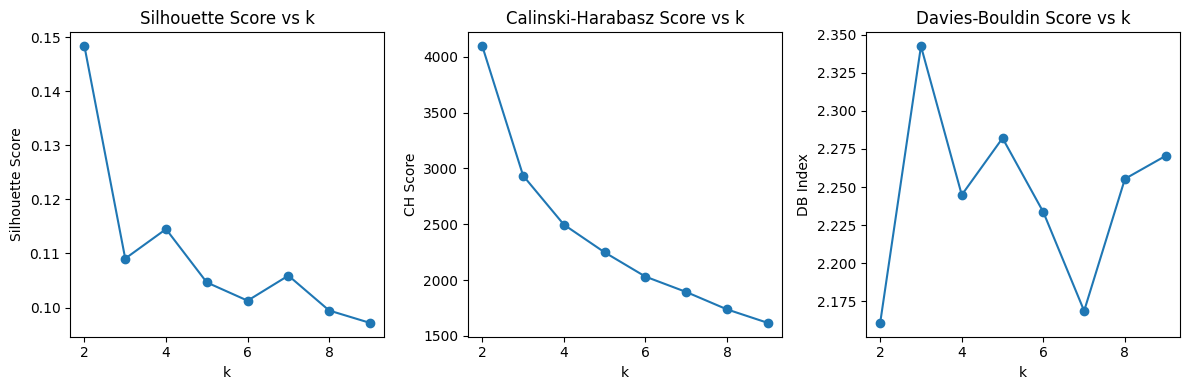

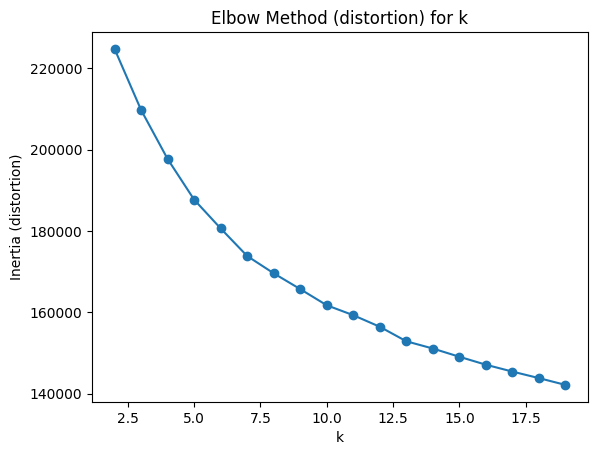


A1 & A2 - Single MFCC Regression (feature '0') Metrics
Train: {'MSE': 0.5680831105237892, 'RMSE': np.float64(0.7537128833473588), 'MAPE': 1365215765721614.0, 'R2': 0.0009497045799052861}
Test : {'MSE': 0.5344432301376904, 'RMSE': np.float64(0.731056242800573), 'MAPE': 1364320264541706.5, 'R2': 0.001886314380816767}

A3 - Multiple MFCC Regression (all MFCCs) Metrics
Train: {'MSE': 0.5636912398351018, 'RMSE': np.float64(0.7507937398747421), 'MAPE': 1353178329492272.0, 'R2': 0.008673397870019861}
Test : {'MSE': 0.532236528771368, 'RMSE': np.float64(0.7295454261191471), 'MAPE': 1355330132370516.8, 'R2': 0.006007498277623702}

A5 - KMeans clustering metrics for k=2 (MFCCs, scaled):
{'Silhouette': np.float64(0.14835746299361807), 'Calinski-Harabasz': np.float64(4096.096906234399), 'Davies-Bouldin': np.float64(2.1608694799350645)}


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Utility: detect MFCC columns (named '0','1',... etc)
def get_mfcc_columns(df):
    # choose columns whose names are digits (e.g., '0','1',... '12')
    mfcc_cols = [c for c in df.columns if c.strip().isdigit()]
    # sort numerically (they are strings)
    mfcc_cols = sorted(mfcc_cols, key=lambda x: int(x))
    return mfcc_cols

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Prepare Train/Test Split
def prepare_data(df, feature_cols, target_col, test_size=0.2, random_state=42):
    X = df[feature_cols]
    y = df[target_col]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Train Linear Regression & Predict
def train_linear_regression(X_train, y_train):
    model = LinearRegression().fit(X_train, y_train)
    return model

# Evaluate Regression Model
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    # MAPE can fail when y_true has zeros; sklearn handles but be aware
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAPE": mape, "R2": r2}

# KMeans Clustering (optionally scale)
def perform_kmeans(X, n_clusters, scale=True):
    X_proc = X.copy()
    if scale:
        scaler = StandardScaler()
        X_proc = scaler.fit_transform(X_proc)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto").fit(X_proc)
    return kmeans, X_proc  # return processed X so metrics use same scaling

# Evaluate Clustering
def evaluate_clustering(X_proc, labels):
    sil = silhouette_score(X_proc, labels)
    ch = calinski_harabasz_score(X_proc, labels)
    db = davies_bouldin_score(X_proc, labels)
    return {"Silhouette": sil, "Calinski-Harabasz": ch, "Davies-Bouldin": db}

# KMeans for different k values (returns scores per k)
def clustering_scores_vs_k(X, k_values, scale=True):
    sil_scores, ch_scores, db_scores = [], [], []
    for k in k_values:
        kmeans, X_proc = perform_kmeans(X, n_clusters=k, scale=scale)
        scores = evaluate_clustering(X_proc, kmeans.labels_)
        sil_scores.append(scores["Silhouette"])
        ch_scores.append(scores["Calinski-Harabasz"])
        db_scores.append(scores["Davies-Bouldin"])
    return sil_scores, ch_scores, db_scores

# Elbow Method (distortions / inertia)
def elbow_method(X, k_range, scale=True):
    distortions = []
    X_proc = X.copy()
    if scale:
        scaler = StandardScaler()
        X_proc = scaler.fit_transform(X_proc)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X_proc)
        distortions.append(kmeans.inertia_)
    return distortions

# Main Execution
if __name__ == "__main__":
    file_path = "/content/drive/MyDrive/ml-stuttering-events-dataset/cleaned-sep28k.csv"
    df = load_data(file_path)

    # detect MFCC columns
    mfcc_cols = get_mfcc_columns(df)
    if not mfcc_cols:
        raise ValueError("No MFCC columns detected. Expected columns named '0','1',...")

    print("Detected MFCC columns:", mfcc_cols)

    # Target for regression exercises (numeric) — per your instruction we'll use 'Prolongation'
    target_col = "Prolongation"

    # A1: Single-attribute regression
    # use the first MFCC (e.g., '0') as the single feature
    single_feature = [mfcc_cols[0]]
    X_train_s, X_test_s, y_train_s, y_test_s = prepare_data(df, feature_cols=single_feature, target_col=target_col)
    reg_single = train_linear_regression(X_train_s, y_train_s)
    y_train_pred_s = reg_single.predict(X_train_s)
    y_test_pred_s = reg_single.predict(X_test_s)
    train_metrics_single = evaluate_regression(y_train_s, y_train_pred_s)
    test_metrics_single = evaluate_regression(y_test_s, y_test_pred_s)

    # A3: Multiple-attribute regression using all MFCCs
    X_train_all, X_test_all, y_train_all, y_test_all = prepare_data(df, feature_cols=mfcc_cols, target_col=target_col)
    reg_multi = train_linear_regression(X_train_all, y_train_all)
    y_train_pred_all = reg_multi.predict(X_train_all)
    y_test_pred_all = reg_multi.predict(X_test_all)
    train_metrics_multi = evaluate_regression(y_train_all, y_train_pred_all)
    test_metrics_multi = evaluate_regression(y_test_all, y_test_pred_all)

    # A4: KMeans clustering (use ONLY MFCCs; drop metadata and labels)
    X_cluster = df[mfcc_cols]  # MFCCs only
    kmeans_2, X_proc_2 = perform_kmeans(X_cluster, n_clusters=2, scale=True)
    cluster_metrics_k2 = evaluate_clustering(X_proc_2, kmeans_2.labels_)

    # A6: clustering scores vs k
    k_values = list(range(2, 10))
    sil_scores, ch_scores, db_scores = clustering_scores_vs_k(X_cluster, k_values, scale=True)

    # plot the three clustering metrics vs k
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(k_values, sil_scores, marker='o')
    plt.title("Silhouette Score vs k")
    plt.xlabel("k"); plt.ylabel("Silhouette Score")

    plt.subplot(1, 3, 2)
    plt.plot(k_values, ch_scores, marker='o')
    plt.title("Calinski-Harabasz Score vs k")
    plt.xlabel("k"); plt.ylabel("CH Score")

    plt.subplot(1, 3, 3)
    plt.plot(k_values, db_scores, marker='o')
    plt.title("Davies-Bouldin Score vs k")
    plt.xlabel("k"); plt.ylabel("DB Index")
    plt.tight_layout()
    plt.show()

    # A7: elbow plot
    k_range = list(range(2, 20))
    distortions = elbow_method(X_cluster, k_range, scale=True)
    plt.figure()
    plt.plot(k_range, distortions, marker='o')
    plt.title("Elbow Method (distortion) for k")
    plt.xlabel("k")
    plt.ylabel("Inertia (distortion)")
    plt.show()

    # Print summary results
    print("\nA1 & A2 - Single MFCC Regression (feature '{}') Metrics".format(single_feature[0]))
    print("Train:", train_metrics_single)
    print("Test :", test_metrics_single)

    print("\nA3 - Multiple MFCC Regression (all MFCCs) Metrics")
    print("Train:", train_metrics_multi)
    print("Test :", test_metrics_multi)

    print("\nA5 - KMeans clustering metrics for k=2 (MFCCs, scaled):")
    print(cluster_metrics_k2)
